<a href="https://www.kaggle.com/code/yaaangzhou/transfomer-pytorch-code-and-learning-note?scriptVersionId=141714400" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Created by Yang Zhou**

**Source Url: https://cloud.tencent.com/developer/article/1885525**

**[中][Transfomer]Source code and Learning Note**

**1 Sep 2023**

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">[中][Transfomer]Source code and Learning Note</center>
***

Transformer是一种重要的自然语言处理（NLP）架构，它在NLP任务中取得了巨大的成功，并且也被应用在其他领域，如计算机视觉和语音识别。Transformer架构的出现标志着一种重大的方法ological转变，它取代了传统的循环神经网络（RNN）和卷积神经网络（CNN），成为当前NLP领域的主要架构。

以下是Transformer的一些背景信息和关键技术：

1. **背景：** 在NLP领域，传统的方法主要依赖于循环神经网络（RNN）和卷积神经网络（CNN）。然而，RNN在处理长序列时存在梯度消失和梯度爆炸的问题，而CNN通常需要固定大小的输入。这些限制限制了它们在处理长文本和捕捉文本中的长距离依赖性方面的性能。

2. **注意力机制：** Transformer引入了一种称为“自注意力（Self-Attention）”机制，它允许模型在输入序列中的不同位置之间建立关联，而不受距离的限制。自注意力机制允许模型根据输入的不同部分来计算注意力权重，这使得模型能够同时关注不同位置的信息，从而更好地捕捉长距离依赖性。

3. **多头自注意力：** Transformer中的自注意力机制通常采用多头注意力的形式，即模型可以学习多个不同的注意力权重，每个头关注输入的不同方面。这有助于模型更好地捕捉多尺度和多粒度的信息。

4. **位置编码：** 由于Transformer不包括RNN或CNN中的位置信息，它引入了一种位置编码来表示输入序列中的位置信息。这使得模型能够理解输入序列中不同位置的相对位置。

5. **残差连接和层归一化：** Transformer中的残差连接和层归一化技术有助于训练更深的神经网络，减轻了梯度消失问题。

6. **Transformer架构：** Transformer由编码器和解码器组成。编码器用于处理输入序列，而解码器用于生成输出序列。这种架构被广泛用于机器翻译（如Google的BERT和OpenAI的GPT系列）等任务。



# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">基本架构</center>

简单来说，Transformers的架构做的事就是在Encoder中不断对输入进行编码，随后将编码后的结果一一输入至解码器。


+ 编码器：
    - 以下是Google论文原文中的示例图，可以看到编码器由N个相同的层堆叠在一起，每一层有两个子层。
    - 编码器的第一个子层是多头注意力层，第二个则是一个全连接层。
    - 每个子层都添加了残差连接和层归一化。
        + 残差连接是何凯明大神提出的为了解决梯度消失的方案，通过不断拟合残差以达到在更深层网络时性能不会下降的问题。
        + 层归一化则区别于批归一化，批归一化相当于对整个batch进行归一化，它会考虑全局的分布。而层归一化则是对独立的每个输入（整句话）进行归一化，也就是它不会考虑其他输入句子的分布。

+ 解码器：
    - 解码器的架构大体上与编码器差不多，区别在于解码器中加入了掩码多头注意力。
    - 掩码多头注意力在这里的作用是遮挡了未来的信息。因为编码器输出了全局信息，而在生成解码器的输出时，如果提前看到了全局信息，可能会造成语法的不连贯。
    - 这也是Transformers的一种妥协。因为RNN本身是可以满足时间序列上逐个输入的效果，但是它无法并行计算，并且对长序列处理不佳。Transformers通过注意力机制解决了长序列的问题，但是它不是顺序输入，而是会看到整个输入。因此需要加入掩码来有意识的遮挡未来的输入。
    
+ 模型输出：
    - 模型的输出是解码器的输出简单加上softmax。输出的是多分类的概率。
    

In [1]:
import torch.nn as nn
import math

## Embedding

Embedding层将文本转变为向量表示，来描述原始数据所包含的信息。

Embedding的初始化函数中要求输入词嵌入维度的大小和词表的大小。举个例子，Bert中的词嵌入大小是768维，词表大小则是30万。

**先通过nn.Embedding将词表中的词汇转变成向量。随后乘以词嵌入维度的开根号。这是为了缩放词嵌入的数值范围。**

_在前向传播中，输入文本的索引张量，输出对应文本的词嵌入向量。_

_例如，如果 x 是一个形状为 (batch_size, sequence_length) 的张量，那么前向传播的输出将是一个形状为 (batch_size, sequence_length, d_model) 的张量，其中 d_model 表示词嵌入的维度，每个单词对应一个 d_model 维的词嵌入向量。_

In [2]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        """
        类的初始化函数
        d_model：指词嵌入的维度
        vocab:指词表的大小
        """
        super(Embeddings, self).__init__()
        #之后就是调用nn中的预定义层Embedding，获得一个词嵌入对象self.lut
        self.lut = nn.Embedding(vocab, d_model)
        #最后就是将d_model传入类中
        self.d_model =d_model
    def forward(self, x):
        """
        Embedding层的前向传播逻辑
        参数x：这里代表输入给模型的单词文本通过词表映射后的one-hot向量
        将x传给self.lut并与根号下self.d_model相乘作为结果返回
        """
        embedds = self.lut(x)
        return embedds * math.sqrt(self.d_model)

# Positional Encoding 位置编码

位置编码主要是给每个token分配位置，这里并没有直接使用绝对的index作为位置编码，而是通过了正余弦函数进行计算。其中Sin函数代表奇数位置，Cos函数代表偶数位置。

计算后，每个token的位置编码将是一个长度为512的向量，这也是为了可以和embedding相加。

初始化函数中，要求输入词嵌入维度，dropout的比例和句子最大长度。

**创建了位置编码的张量，大小是(max_len, d_model)。这代表着每个token的位置编码。**

_前向传播中，接受词嵌入的输入维度(batch_size, sequence_length, d_model)。在计算出位置编码的512维向量后，对应相加，最后同样输出维度为(batch_size, sequence_length, d_model)的张量。与输入的区别只在于添加了位置信息。_

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        """
        位置编码器类的初始化函数
        
        共有三个参数，分别是
        d_model：词嵌入维度
        dropout: dropout触发比率
        max_len：每个句子的最大长度
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings
        pe = torch.zeros(max_len, d_model) # 构建位置编码的张量
        position = torch.arange(0, max_len).unsqueeze(1) # 将每个token的位置（即从0到max_len-1）变为列向量
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model)) # 计算
        pe[:, 0::2] = torch.sin(position * div_term) # 使用了广播机制分配pe的不同列。这代表着从第0行开始每隔两列取一列。返回所有偶数位置的编码。
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # 最后增加了一个维度，也就是batch的维度。
        self.register_buffer('pe', pe) #将位置编码张量存储在模型中。这是因为位置编码不需要进行训练，因此可以将其视为模型的一个固定部分。
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

# Inputs of Encoders and Decoders

Encoder和Decoder都包含输入模块。其中，编码器只进行一次推理，用于将Input的文本推理为向量表示。

而Decoder则是类似于RNN一样逐步输入。这也是为什么之前提到需要用掩码遮掉未来的信息。因为需要用Encoder的输出，一步步输入Decoder。例如机器翻译任务中，输入如果是**我来自中国**，那么得到向量表示后，解码器将根据预测的第一个单词**I**输入解码器，然后根据下一个预测逐步完成整个句子的翻译。

_简单说，解码器的输入包括：编码器的完整输出，上一个时刻编码器的输出。_

# Encoder 编码器

编码器由多个编码器层组成。

以下函数中，clones用于复制给定的模块 module 并创建一个包含 N 个相同模块的模块列表（nn.ModuleList）。

_Encoder是编码器的类，其中接受的参数是编码器层layer和层数。self.layers 是一个列表，其中包含了多个相同的编码器层（Encoder Layer）。每个元素都是一个编码器层的实例。_

_前向传播时，编码器将输入张量 x 和一个掩码张量 mask 传递给每个编码器层。它会依次遍历 self.layers 中的每个编码器层，将输入 x 传递给每一层，并将每一层的输出作为下一层的输入。最终，返回编码器层处理后的输出，并通过层归一化 self.norm 进行最终的归一化操作。_

In [4]:
# 定义一个clones函数，来更方便的将某个结构复制若干份
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class Encoder(nn.Module):
    """
    Encoder
    The encoder is composed of a stack of N=6 identical layers.
    """
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        # 调用时会将编码器层传进来，我们简单克隆N分，叠加在一起，组成完整的Encoder
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

# 编码器层

具体看一下编码器层：每个编码器层都有两个子层：多头注意力和全连接层。其中每个子层都使用了残差连接。


以下是一个子层残差连接的结构。

In [5]:
class SublayerConnection(nn.Module):
    """ 
    实现子层连接结构的类
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        sublayer_out = sublayer(x)
        x_norm = self.norm(x + self.dropout(sublayer_out))

        return x_norm

现在就可以实现编码器层的结构。解码器接受四个参数，分别是：
+ size：编码器的输出维度
+ self_attn：自注意力机制模块
+ feed_forward：全连接前馈模块
+ drop_out：drop out的比例

_前向传播中，编码器接受之前得到的Embedding+位置编码的张量x，以及一个掩码张量mask。x和mask先输入自注意层，随后将结果输入前馈神经网络。_

In [6]:
class EncoderLayer(nn.Module):
    "EncoderLayer is made up of two sublayer: self-attn and feed forward"                                                                                                         
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size   # embedding's dimention of model, 默认512

    def forward(self, x, mask):
        # attention sub layer
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # feed forward sub layer
        z = self.sublayer[1](x, self.feed_forward)
        return z

# Attention 注意力机制

注意力机制就不完整介绍了。简单来说就是输入Query,Key,Value,得到每个Query对应Key的注意力值。

在自注意力机制中，一句话的每个token输入将会对句子中的每个输入有一个注意力值。这个注意力值是由softmax产生的概率值，表示当前token对整句话中所有token的注意力（或是权重）。而这种情况下，Q,K,V都是同样的矩阵，大小为(Length,Hidden State)。

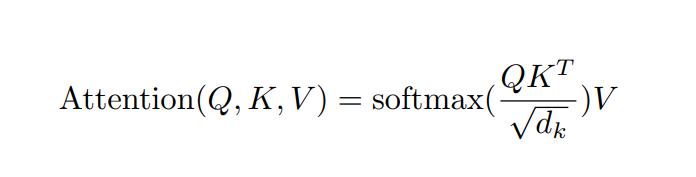


attention函数接受几个参数：Q,K,V即输入的文本向量。

d_k是Query最后一维的大小，也就是最后一个token的长度，意思是词嵌入的维度。

scores是得到的注意力分数矩阵。

**值得注意的一点，key矩阵的大小为(batch_size, sequence_length, embedding_dim)，key.transpose(-2, -1)的意思就是将后面两个维度进行交换，这样才能进行矩阵乘法。**

接下来，查看是否使用了掩码mask，如果使用了，就将注意力分数矩阵中相应位置为0的位置替换为一个较大的负值。这样在softmax计算中，该token的权重会被下降。

然后使用 F.softmax 函数对注意力分数矩阵 scores 进行softmax操作，以获得最终的注意力权重张量 p_attn。这个张量表示了每个查询位置对应的注意力权重。

_attention函数的输出是两个部分：_

_自注意力输出（Self-Attention Output）： 这是通过将注意力权重矩阵 p_attn 与值张量 value 相乘得到的。它表示了每个查询位置对应的自注意力加权值，即模型在处理输入序列时，为每个位置分配的权重。这个自注意力输出包含了位置间的关联性信息。_

_注意力权重张量（Attention Weights Tensor）： 这是由 softmax 操作得到的注意力权重张量 p_attn。它表示了每个查询位置对应的注意力权重分布，即模型关注输入序列中的哪些位置。这个注意力权重张量用于可视化或进一步的分析。_

_注意，其中的自注意输出将被输入下一层。_

In [7]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"

    #首先取query的最后一维的大小，对应词嵌入维度
    d_k = query.size(-1)
    #按照注意力公式，将query与key的转置相乘，这里面key是将最后两个维度进行转置，再除以缩放系数得到注意力得分张量scores
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    
    #接着判断是否使用掩码张量
    if mask is not None:
        #使用tensor的masked_fill方法，将掩码张量和scores张量每个位置一一比较，如果掩码张量则对应的scores张量用-1e9这个置来替换
        scores = scores.masked_fill(mask == 0, -1e9)
        
    #对scores的最后一维进行softmax操作，使用F.softmax方法，这样获得最终的注意力张量
    p_attn = F.softmax(scores, dim = -1)
    
    #之后判断是否使用dropout进行随机置0
    if dropout is not None:
        p_attn = dropout(p_attn)
    
    #最后，根据公式将p_attn与value张量相乘获得最终的query注意力表示，同时返回注意力张量
    return torch.matmul(p_attn, value), p_attn

# Multi-Headed Attention 多头注意力机制

多头注意力有点像CV中的卷积核，它将词汇的Embedding根据不同的注意力头分成不同的部分，并分别计算每个注意力头的注意力值。这相当于根据不同语义的主题分别计算注意力。

在计算时，Q,K,V被均分成数个矩阵，随后进入线性层实例化。

_前向传播时，一样是输入Q,K,V矩阵，最终输出是经过线性映射后的张量，其大小是 (batch_size, sequence_length, d_model)。_


In [8]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        #在类的初始化时，会传入三个参数，h代表头数，d_model代表词嵌入的维度，dropout代表进行dropout操作时置0比率，默认是0.1
        super(MultiHeadedAttention, self).__init__()
        #在函数中，首先使用了一个测试中常用的assert语句，判断h是否能被d_model整除，这是因为我们之后要给每个头分配等量的词特征，也就是embedding_dim/head个
        assert d_model % h == 0
        #得到每个头获得的分割词向量维度d_k
        self.d_k = d_model // h
        #传入头数h
        self.h = h
        
        #创建linear层，通过nn的Linear实例化，它的内部变换矩阵是embedding_dim x embedding_dim，然后使用，为什么是四个呢，这是因为在多头注意力中，Q,K,V各需要一个，最后拼接的矩阵还需要一个，因此一共是四个
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        #self.attn为None，它代表最后得到的注意力张量，现在还没有结果所以为None
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        #前向逻辑函数，它输入参数有四个，前三个就是注意力机制需要的Q,K,V，最后一个是注意力机制中可能需要的mask掩码张量，默认是None
        if mask is not None:
            # Same mask applied to all h heads.
            #使用unsqueeze扩展维度，代表多头中的第n头
            mask = mask.unsqueeze(1)
        #接着，我们获得一个batch_size的变量，他是query尺寸的第1个数字，代表有多少条样本
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        # 首先利用zip将输入QKV与三个线性层组到一起，然后利用for循环，将输入QKV分别传到线性层中，做完线性变换后，开始为每个头分割输入，这里使用view方法对线性变换的结构进行维度重塑，多加了一个维度h代表头，这样就意味着每个头可以获得一部分词特征组成的句子，其中的-1代表自适应维度，计算机会根据这种变换自动计算这里的值，然后对第二维和第三维进行转置操作，为了让代表句子长度维度和词向量维度能够相邻，这样注意力机制才能找到词义与句子位置的关系，从attention函数中可以看到，利用的是原始输入的倒数第一和第二维，这样我们就得到了每个头的输入
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch. 
        # 得到每个头的输入后，接下来就是将他们传入到attention中，这里直接调用我们之前实现的attention函数，同时也将mask和dropout传入其中
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear. 
        # 通过多头注意力计算后，我们就得到了每个头计算结果组成的4维张量，我们需要将其转换为输入的形状以方便后续的计算，因此这里开始进行第一步处理环节的逆操作，先对第二和第三维进行转置，然后使用contiguous方法。这个方法的作用就是能够让转置后的张量应用view方法，否则将无法直接使用，所以，下一步就是使用view重塑形状，变成和输入形状相同。  
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        #最后使用线性层列表中的最后一个线性变换得到最终的多头注意力结构的输出
        return self.linears[-1](x)

# Feed Forward Layer 前馈全连接层

前馈全连接层就是简单的两个全连接层，在进行了Attention操作之后，encoder和decoder中的每一层都包含了一个全连接前向网络，对每个position的向量分别进行相同的操作，包括两个线性变换和一个ReLU激活输出。

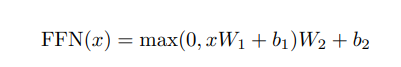

In [9]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        #初始化函数有三个输入参数分别是d_model，d_ff，和dropout=0.1，第一个是线性层的输入维度也是第二个线性层的输出维度，因为我们希望输入通过前馈全连接层后输入和输出的维度不变，第二个参数d_ff就是第二个线性层的输入维度和第一个线性层的输出，最后一个是dropout置0比率。
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #输入参数为x，代表来自上一层的输出，首先经过第一个线性层，然后使用F中的relu函数进行激活，之后再使用dropout进行随机置0，最后通过第二个线性层w2，返回最终结果
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

# Layer Normalization 层归一化

这个没什么好解释的，就是对每个句子的输入进行归一化。

In [10]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, feature_size, eps=1e-6):
        #初始化函数有两个参数，一个是features,表示词嵌入的维度,另一个是eps它是一个足够小的数，在规范化公式的分母中出现,防止分母为0，默认是1e-6。
        super(LayerNorm, self).__init__()
        #根据features的形状初始化两个参数张量a2，和b2，第一初始化为1张量，也就是里面的元素都是1，第二个初始化为0张量，也就是里面的元素都是0，这两个张量就是规范化层的参数。因为直接对上一层得到的结果做规范化公式计算，将改变结果的正常表征，因此就需要有参数作为调节因子，使其即能满足规范化要求，又能不改变针对目标的表征，最后使用nn.parameter封装，代表他们是模型的参数
        self.a_2 = nn.Parameter(torch.ones(feature_size))
        self.b_2 = nn.Parameter(torch.zeros(feature_size))
        #把eps传到类中
        self.eps = eps

    def forward(self, x):
    #输入参数x代表来自上一层的输出，在函数中，首先对输入变量x求其最后一个维度的均值，并保持输出维度与输入维度一致，接着再求最后一个维度的标准差，然后就是根据规范化公式，用x减去均值除以标准差获得规范化的结果。
    #最后对结果乘以我们的缩放参数，即a2,*号代表同型点乘，即对应位置进行乘法操作，加上位移参b2，返回即可
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

# Mask 掩码

掩码的作用：在transformer中，掩码主要的作用有两个，一个是屏蔽掉无效的padding区域，一个是屏蔽掉来自“未来”的信息。Encoder中的掩码主要是起到第一个作用，Decoder中的掩码则同时发挥着两种作用。

在Encoder中，Mask只是一个上三角矩阵，size是输入语句的大小，下三角部分被设置为0，意思是将未来的信息都设置为0。


In [11]:
def subsequent_mask(size):
    #生成向后遮掩的掩码张量，参数size是掩码张量最后两个维度的大小，它最后两维形成一个方阵

    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    
    #然后使用np.ones方法向这个形状中添加1元素，形成上三角阵
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')

    #最后将numpy类型转化为torch中的tensor，内部做一个1- 的操作。这个其实是做了一个三角阵的反转，subsequent_mask中的每个元素都会被1减。
    #如果是0，subsequent_mask中的该位置由0变成1
    #如果是1，subsequect_mask中的该位置由1变成0
    return torch.from_numpy(subsequent_mask) == 0

# Decoder 解码器

解码器和编码器结构差不多，不过前向传播中参数多了编码层的输入以及源数据的掩码和目标数据的掩码。

它的作用就是根据编码器的结果以及上一次预测的结果，输出序列的下一个结果。

In [12]:
#使用类Decoder来实现解码器
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        #初始化函数的参数有两个，第一个就是解码器层layer，第二个是解码器层的个数N
        super(Decoder, self).__init__()
        #首先使用clones方法克隆了N个layer，然后实例化一个规范化层，因为数据走过了所有的解码器层后最后要做规范化处理。
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        #forward函数中的参数有4个，x代表目标数据的嵌入表示，memory是编码器层的输出，source_mask，target_mask代表源数据和目标数据的掩码张量，然后就是对每个层进行循环，当然这个循环就是变量x通过每一个层的处理，得出最后的结果，再进行一次规范化返回即可。
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

# Decoder Layer 解码器层

In [13]:
#使用DecoderLayer的类实现解码器层
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        #初始化函数的参数有5个，分别是size，代表词嵌入的维度大小，同时也代表解码器的尺寸，第二个是self_attn，多头自注意力对象，也就是说这个注意力机制需要Q=K=V，第三个是src_attn,多头注意力对象，这里Q!=K=V，第四个是前馈全连接层对象，最后就是dropout置0比率
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        #按照结构图使用clones函数克隆三个子层连接对象
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        #forward函数中的参数有4个，分别是来自上一层的输入x，来自编码器层的语义存储变量memory，以及源数据掩码张量和目标数据掩码张量，将memory表示成m之后方便使用。
        "Follow Figure 1 (right) for connections."
        m = memory
        #将x传入第一个子层结构，第一个子层结构的输入分别是x和self-attn函数，因为是自注意力机制，所以Q,K,V都是x，最后一个参数时目标数据掩码张量，这时要对目标数据进行遮掩，因为此时模型可能还没有生成任何目标数据。
        #比如在解码器准备生成第一个字符或词汇时，我们其实已经传入了第一个字符以便计算损失，但是我们不希望在生成第一个字符时模型能利用这个信息，因此我们会将其遮掩，同样生成第二个字符或词汇时，模型只能使用第一个字符或词汇信息，第二个字符以及之后的信息都不允许被模型使用。
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        #接着进入第二个子层，这个子层中常规的注意力机制，q是输入x;k,v是编码层输出memory，同样也传入source_mask，但是进行源数据遮掩的原因并非是抑制信息泄露，而是遮蔽掉对结果没有意义的padding。
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        
        #最后一个子层就是前馈全连接子层，经过它的处理后就可以返回结果，这就是我们的解码器结构
        return self.sublayer[2](x, self.feed_forward)

# Output of model 模型输出

模型的输出是对每一个时间的输出都加上一个线性层和一个softmax层，以输出预测的token。

In [14]:
#将线性层和softmax计算层一起实现，因为二者的共同目标是生成最后的结构
#因此把类的名字叫做Generator，生成器类
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        #初始化函数的输入参数有两个，d_model代表词嵌入维度，vocab.size代表词表大小
        super(Generator, self).__init__()
        #首先就是使用nn中的预定义线性层进行实例化，得到一个对象self.proj等待使用
        #这个线性层的参数有两个，就是初始化函数传进来的两个参数：d_model，vocab_size
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        #前向逻辑函数中输入是上一层的输出张量x,在函数中，首先使用上一步得到的self.proj对x进行线性变化,然后使用F中已经实现的log_softmax进行softmax处理。
        return F.log_softmax(self.proj(x), dim=-1)

# Model Architecture 模型构建

In [15]:
# Model Architecture
#使用EncoderDecoder类来实现编码器-解码器结构
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. 
    Base for this and many other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        #初始化函数中有5个参数，分别是编码器对象，解码器对象,源数据嵌入函数，目标数据嵌入函数，以及输出部分的类别生成器对象.
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed    # input embedding module(input embedding + positional encode)
        self.tgt_embed = tgt_embed    # ouput embedding module
        self.generator = generator    # output generation module
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        #在forward函数中，有四个参数，source代表源数据，target代表目标数据,source_mask和target_mask代表对应的掩码张量,在函数中，将source source_mask传入编码函数，得到结果后与source_mask target 和target_mask一同传给解码函数
        memory = self.encode(src, src_mask)
        res = self.decode(memory, src_mask, tgt, tgt_mask)
        return res
    
    def encode(self, src, src_mask):
        #编码函数，以source和source_mask为参数,使用src_embed对source做处理，然后和source_mask一起传给self.encoder
        src_embedds = self.src_embed(src)
        return self.encoder(src_embedds, src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        #解码函数，以memory即编码器的输出，source_mask target target_mask为参数,使用tgt_embed对target做处理，然后和source_mask,target_mask,memory一起传给self.decoder
        target_embedds = self.tgt_embed(tgt)
        return self.decoder(target_embedds, memory, src_mask, tgt_mask)


# Full Model
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    """
    构建模型
    params:
        src_vocab:
        tgt_vocab:
        N: 编码器和解码器堆叠基础模块的个数
        d_model: 模型中embedding的size，默认512
        d_ff: FeedForward Layer层中embedding的size，默认2048
        h: MultiHeadAttention中多头的个数，必须被d_model整除
        dropout:
    """
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model